# Análisis de Componentes Principales

#### _3.1 Estudie si es posible hacer transformaciones en las variables categóricas para incluirlas en el PCA, ¿valdrá la pena?_

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.pipeline import make_pipeline
import numpy as np

In [103]:
# Cargar los datos
file_path = "movies.csv"  # Asegúrate de cambiar esto por la ruta correcta si ejecutas localmente
df = pd.read_csv(file_path, encoding="ISO-8859-1")

In [104]:
# Variables categóricas
categorical_columns = ['homePage', 'video', 'director', 'originalTitle', 'title', 'originalLanguage',
                       'genres', 'actors', 'actorsCharacter', 'productionCompanyCountry',
                       'productionCountry', 'productionCompany']

# Contar cuántas categorías únicas tiene cada variable categórica después de separar por '|'
categories_count = {}
for col in categorical_columns:
    unique_values = set()
    df[col].dropna().apply(lambda x: unique_values.update(x.split('|')) if '|' in str(x) else unique_values.add(x))
    categories_count[col] = len(unique_values)

# Mostrar los resultados en una tabla
df_categories = pd.DataFrame.from_dict(categories_count, orient='index', columns=['Unique Categories'])
df_categories = df_categories.sort_values(by='Unique Categories', ascending=False)
print("Cantidad de categorías únicas por variable categórica:")
print(df_categories)

Cantidad de categorías únicas por variable categórica:
                          Unique Categories
actorsCharacter                      164023
actors                               132626
productionCompany                     10142
originalTitle                          9761
title                                  9697
director                               6008
homePage                               4125
productionCountry                       111
productionCompanyCountry                 86
originalLanguage                         40
genres                                   19
video                                     2


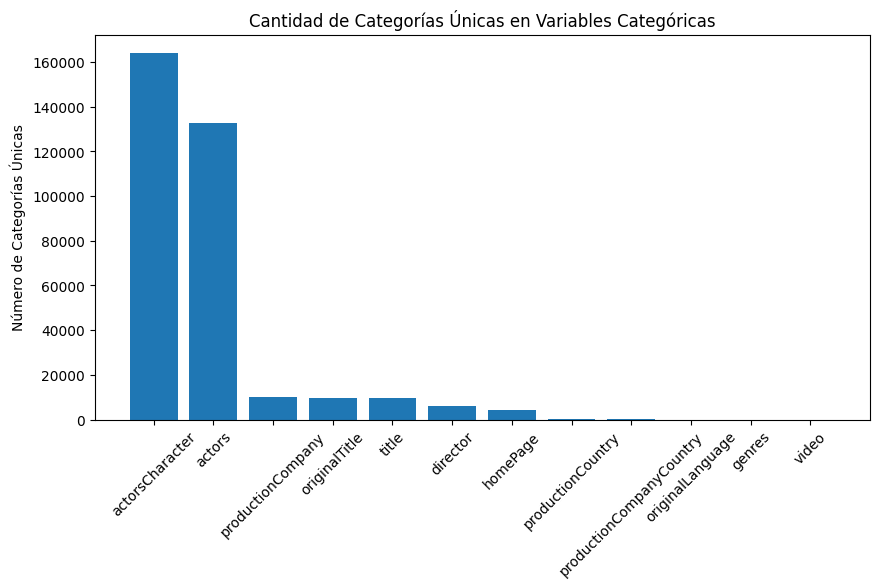

In [105]:
# Graficar
plt.figure(figsize=(10, 5))
plt.bar(df_categories.index, df_categories['Unique Categories'])
plt.xticks(rotation=45)
plt.ylabel("Número de Categorías Únicas")
plt.title("Cantidad de Categorías Únicas en Variables Categóricas")
plt.show()

In [106]:
# Aplicar One-Hot Encoding a una muestra reducida para demostrar expansión
sample_size = 500  # Reducimos el tamaño para evitar alta dimensionalidad
df_sample = df[categorical_columns].sample(sample_size, random_state=42)

def one_hot_encode_column(column):
    """Aplica One-Hot Encoding a una columna con valores separados por '|' correctamente"""
    # Expandir cada categoría en columnas separadas
    expanded_series = df_sample[column].fillna('').astype(str).str.get_dummies(sep='|')
    return expanded_series.shape[1]  # Número de columnas creadas

# Evaluar la expansión de dimensiones
ohe_expansion = {col: one_hot_encode_column(col) for col in categorical_columns}
df_ohe_expansion = pd.DataFrame.from_dict(ohe_expansion, orient='index', columns=['New Columns After OHE'])

print("Número de columnas nuevas creadas tras aplicar One-Hot Encoding:")
print(df_ohe_expansion)

Número de columnas nuevas creadas tras aplicar One-Hot Encoding:
                          New Columns After OHE
homePage                                    207
video                                         2
director                                    537
originalTitle                               497
title                                       497
originalLanguage                             20
genres                                       19
actors                                    11509
actorsCharacter                           11003
productionCompanyCountry                     44
productionCountry                            44
productionCompany                          1001


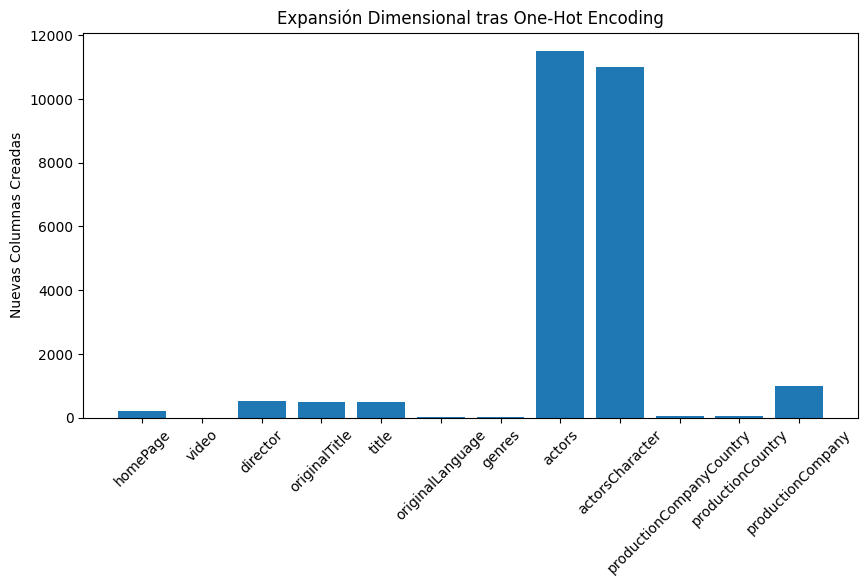

In [107]:
# Graficar expansión dimensional
plt.figure(figsize=(10, 5))
plt.bar(df_ohe_expansion.index, df_ohe_expansion['New Columns After OHE'])
plt.xticks(rotation=45)
plt.ylabel("Nuevas Columnas Creadas")
plt.title("Expansión Dimensional tras One-Hot Encoding")
plt.show()

In [108]:
# Determinar variables viables y no viables dinámicamente
threshold = 100  # Definir un umbral para considerar una variable como no viable
viable_variables = list(df_ohe_expansion[df_ohe_expansion['New Columns After OHE'] <= threshold].index)
non_viable_variables = list(df_ohe_expansion[df_ohe_expansion['New Columns After OHE'] > threshold].index)

print("\nVariables Viables para PCA:", viable_variables)
print("Variables NO Viables para PCA:", non_viable_variables)



Variables Viables para PCA: ['video', 'originalLanguage', 'genres', 'productionCompanyCountry', 'productionCountry']
Variables NO Viables para PCA: ['homePage', 'director', 'originalTitle', 'title', 'actors', 'actorsCharacter', 'productionCompany']


<small>

### **Conclusión: ¿Por qué es mejor trabajar solo con las variables numéricas en PCA?**

Después de analizar las variables categóricas y determinar cuáles son viables y no viables para PCA, la mejor opción es **trabajar solo con las variables numéricas**. Aquí está el **razonamiento técnico y práctico** que respalda esta decisión:

---

### **1. Evitar la Explosión Dimensional**
- Como vimos en el análisis, aplicar **One-Hot Encoding** a ciertas variables categóricas (como `actors`, `genres`, `productionCompany`) genera **cientos o miles de nuevas columnas**.
- PCA busca **reducir la dimensionalidad**, pero si aumentamos artificialmente la cantidad de variables, estaríamos **complicando el modelo en lugar de simplificarlo**.

✅ **Las variables numéricas ya tienen una estructura manejable para PCA sin necesidad de expansión.**

---

### **2. PCA se basa en Variabilidad Numérica**
- PCA funciona encontrando direcciones en los datos donde hay **mayor variabilidad**.
- **Variables categóricas transformadas con One-Hot Encoding solo generan 0 y 1**, lo que:
  - **No aporta una variabilidad continua.**
  - **Puede sesgar el PCA** porque ciertas categorías pueden dominar artificialmente la transformación.

✅ **Las variables numéricas tienen rangos de valores reales y continuos, lo que las hace más adecuadas para PCA.**

---

### **3. Variables Numéricas ya Capturan Información de las Categóricas**
- Muchas variables categóricas ya están **resumidas en variables numéricas**, por ejemplo:
  - `genresAmount` → Resume cuántos géneros tiene una película.
  - `actorsAmount` → Indica cuántos actores tiene una película.
  - `productionCoAmount` → Mide cuántas compañías produjeron la película.
  - `actorsPopularity` → Puede transformarse en un promedio de popularidad de actores.

✅ **Estas variables ya sintetizan información categórica sin necesidad de expansión.**

---

### **4. Interpretabilidad y Eficiencia**
- Un PCA con demasiadas variables **complica la interpretación**.
- Si incluimos **variables categóricas mal transformadas**, los componentes principales pueden ser difíciles de entender.
- **El modelo será más eficiente si se entrena solo con variables numéricas**, ya que:
  - Se reducen los cálculos innecesarios.
  - Se obtiene una mejor relación señal/ruido.

✅ **Usar solo variables numéricas permite un PCA más claro, eficiente e interpretable.**

---

### **Conclusión Final**
Dado que:
- **One-Hot Encoding genera un aumento drástico en la dimensionalidad**.
- **Las variables categóricas transformadas no aportan una variabilidad útil para PCA**.
- **Ya tenemos variables numéricas que resumen información categórica**.
- **Un PCA con variables numéricas será más eficiente y fácil de interpretar**.

➡ **Es mejor aplicar PCA solo sobre las variables numéricas.** 🚀

</small>

#### _3.2 Estudie si es conveniente hacer un Análisis de Componentes Principales. Recuerde que puede usar el índice KMO y el test de esfericidad de Bartlett._


Test de Esfericidad de Bartlett: Chi-cuadrado = 34446.4291398239, p-valor = 0.0
Índice KMO: 0.7166360085256622


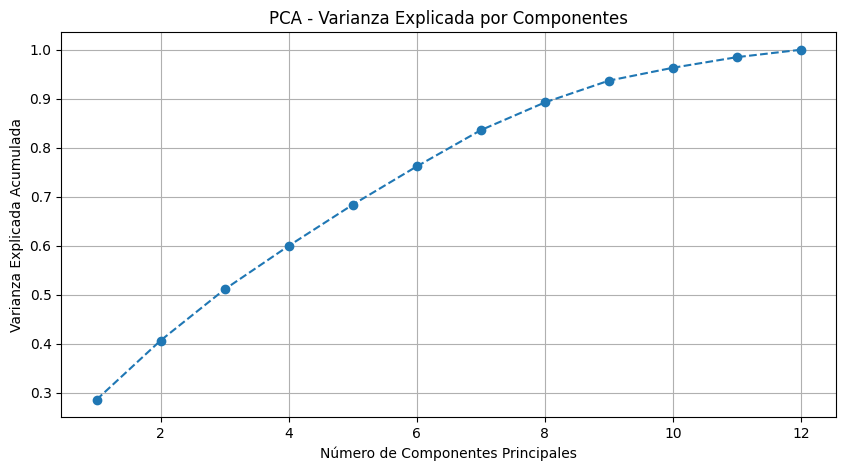

Número de componentes principales que explican al menos el 90% de la varianza: 9


In [109]:
# Seleccionar solo variables numéricas para PCA
numerical_columns = ['budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount',
                     'genresAmount', 'productionCoAmount', 'productionCountriesAmount', 'actorsAmount',
                     'castWomenAmount', 'castMenAmount']

# Convertir columnas numéricas a valores numéricos, forzando errores a NaN
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas con NaN en columnas numéricas
df = df.dropna(subset=numerical_columns)

# Continuar con el análisis
# Análisis de Componentes Principales: Test de Esfericidad de Bartlett y KMO

# Seleccionar solo variables numéricas para PCA
df_numerical = df[numerical_columns]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical)

# Test de Esfericidad de Bartlett
bartlett_test, bartlett_p_value = calculate_bartlett_sphericity(df_scaled)
print(f"Test de Esfericidad de Bartlett: Chi-cuadrado = {bartlett_test}, p-valor = {bartlett_p_value}")

# Índice KMO
kmo_all, kmo_model = calculate_kmo(df_scaled)
print(f"Índice KMO: {kmo_model}")

# Aplicamos PCA
pca = PCA()
pca_components = pca.fit_transform(df_scaled)

# Explicación de la varianza
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Gráfico de la varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("PCA - Varianza Explicada por Componentes")
plt.grid()
plt.show()

# Determinar cuántos componentes principales explican al menos el 90% de la varianza
num_components_90 = (cumulative_variance >= 0.90).argmax() + 1
print(f"Número de componentes principales que explican al menos el 90% de la varianza: {num_components_90}")


<small>

### **Conclusión del Análisis PCA**

### **1. Adecuación del PCA según Bartlett y KMO**
El **Test de Esfericidad de Bartlett** arroja un **p-valor de 0.0**, lo que indica que las variables presentan correlaciones significativas y no son una matriz identidad. Esto confirma que el **PCA es adecuado** para reducir la dimensionalidad del conjunto de datos.

El **índice KMO** obtenido es **0.7166**, lo que sugiere que los datos tienen una estructura suficiente para aplicar PCA, aunque no en un nivel óptimo. Esto implica que el PCA puede mejorar el análisis de las relaciones entre las variables.

---

### **2. Análisis de la Varianza Explicada**
El gráfico de **Varianza Explicada por Componentes** muestra cómo cada componente principal contribuye a la varianza total del conjunto de datos. Se observa que:

- A medida que se agregan más componentes principales, la varianza explicada acumulada aumenta.
- Se alcanza el **90% de la varianza con solo 9 componentes principales** en lugar de las 12 variables originales.
- Esto significa que **se logra una reducción de dimensionalidad sin perder demasiada información clave**.

---

### **3. Implicaciones del PCA**
- El análisis confirma que se pueden **reducir las 12 variables numéricas a 9 componentes principales**, lo que simplifica el conjunto de datos manteniendo la mayor parte de su variabilidad.
- Esta reducción **mejorará la eficiencia de modelos de Machine Learning** y facilitará la interpretación de los datos sin comprometer la información clave.
- Al evitar la transformación de variables categóricas en miles de columnas (por **One-Hot Encoding**), el PCA demuestra ser una mejor opción para la reducción de dimensionalidad.

---

### **Conclusión Final**
✅ **El PCA es adecuado según los tests previos (Bartlett y KMO).**  
✅ **Se recomienda utilizar los primeros 9 componentes principales para representar los datos de manera eficiente.**  
✅ **Se logra una reducción significativa de la dimensionalidad sin perder información clave.**

</small>


#### _3.3 Haga un análisis de componentes principales con las variables numéricas, discuta los resultados e interprete los componentes._

In [110]:
# Crear pipeline de escalado y PCA con 9 componentes
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=9))
pca_pipe.fit(df_numerical)

# Extraer modelo PCA del pipeline
modelo_pca = pca_pipe.named_steps['pca']
print(f'Cantidad de Componentes Generados: {modelo_pca.n_components_}')

Cantidad de Componentes Generados: 9


In [111]:
# Convertir las cargas en un DataFrame
pca_df = pd.DataFrame(
    data=modelo_pca.components_,
    columns=numerical_columns,
    index=[f'PC{i+1}' for i in range(modelo_pca.n_components_)]
)
print("Resultado del PCA:")
print(pca_df)

Resultado del PCA:
       budget   revenue   runtime  popularity   voteAvg  voteCount  \
PC1  0.430941  0.439915  0.278647    0.098816  0.146291   0.439289   
PC2  0.101239  0.145027 -0.018006    0.090621 -0.007263   0.109138   
PC3 -0.250545 -0.313184  0.315101   -0.349885 -0.063119  -0.213878   
PC4 -0.191990 -0.132171  0.386050    0.096513  0.786153   0.016475   
PC5  0.125718 -0.046821 -0.032070   -0.130171 -0.314737  -0.100499   
PC6 -0.033139 -0.109426  0.057325    0.877658 -0.185280  -0.164647   
PC7 -0.161915 -0.198870 -0.135766    0.236916  0.165533  -0.193745   
PC8  0.119227 -0.021245  0.786306    0.028408 -0.352809  -0.173145   
PC9 -0.013251 -0.073986  0.055960    0.003945 -0.007042  -0.063332   

     genresAmount  productionCoAmount  productionCountriesAmount  \
PC1      0.111956            0.140467                  -0.052597   
PC2     -0.149265           -0.148647                   0.659857   
PC3     -0.332385            0.229832                   0.181080   
PC4     

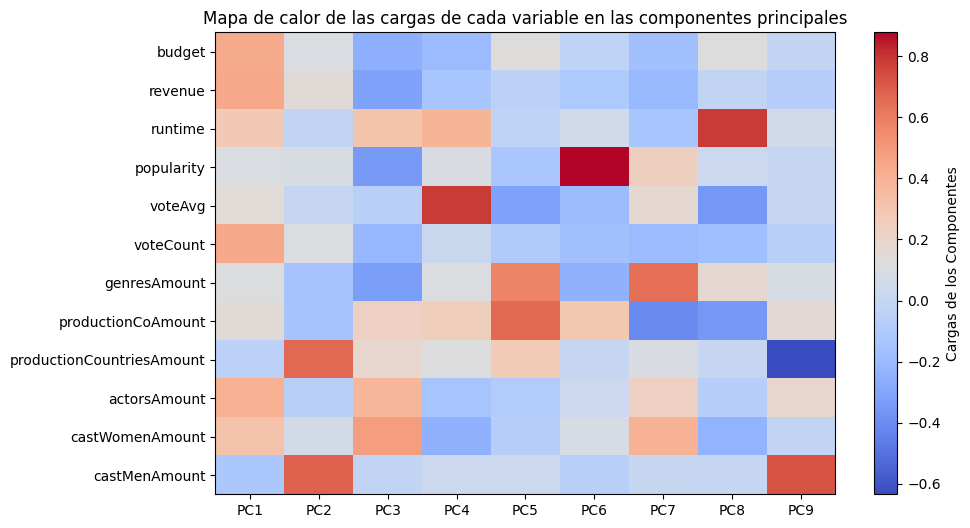

In [112]:
# Representación visual de la contribución de cada variable en las componentes principales
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(modelo_pca.components_.T, cmap='coolwarm', aspect='auto')
plt.yticks(range(len(numerical_columns)), numerical_columns)
plt.xticks(range(modelo_pca.n_components_), [f'PC{i+1}' for i in range(modelo_pca.n_components_)])
plt.colorbar(label='Cargas de los Componentes')
plt.title('Mapa de calor de las cargas de cada variable en las componentes principales')
plt.show()

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
[0.28561518 0.12079763 0.10439276 0.08876682 0.08410668 0.07811226
 0.07404608 0.05656369 0.04452896]


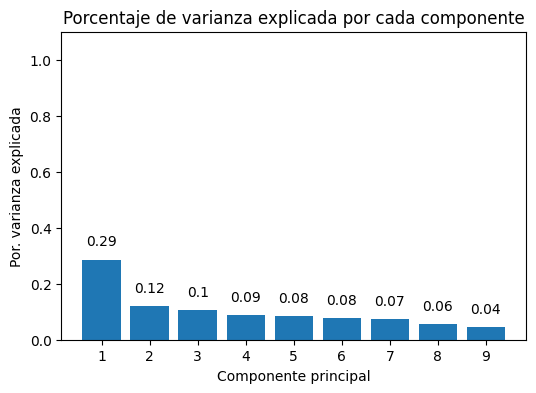

In [113]:
# Porcentaje de varianza explicada por cada componente
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

# Scree plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    x=np.arange(modelo_pca.n_components_) + 1,
    height=modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
plt.show()

In [114]:
# Mostrar las cargas de los primeros 4 componentes
cargas = modelo_pca.components_[:4]

for i, carga in enumerate(cargas):
    print(f'Componente {i+1}:')
    for j, variable in enumerate(numerical_columns):
        print(f'  {variable}: {carga[j]:.3f}')
    print('---')

Componente 1:
  budget: 0.431
  revenue: 0.440
  runtime: 0.279
  popularity: 0.099
  voteAvg: 0.146
  voteCount: 0.439
  genresAmount: 0.112
  productionCoAmount: 0.140
  productionCountriesAmount: -0.053
  actorsAmount: 0.407
  castWomenAmount: 0.322
  castMenAmount: -0.120
---
Componente 2:
  budget: 0.101
  revenue: 0.145
  runtime: -0.018
  popularity: 0.091
  voteAvg: -0.007
  voteCount: 0.109
  genresAmount: -0.149
  productionCoAmount: -0.149
  productionCountriesAmount: 0.660
  actorsAmount: -0.063
  castWomenAmount: 0.066
  castMenAmount: 0.678
---
Componente 3:
  budget: -0.251
  revenue: -0.313
  runtime: 0.315
  popularity: -0.350
  voteAvg: -0.063
  voteCount: -0.214
  genresAmount: -0.332
  productionCoAmount: 0.230
  productionCountriesAmount: 0.181
  actorsAmount: 0.380
  castWomenAmount: 0.477
  castMenAmount: -0.017
---
Componente 4:
  budget: -0.192
  revenue: -0.132
  runtime: 0.386
  popularity: 0.097
  voteAvg: 0.786
  voteCount: 0.016
  genresAmount: 0.104
  pro

In [115]:
# Transformar los datos al espacio reducido de 9 componentes
X_reducido = modelo_pca.transform(df_numerical)
print("Datos transformados con PCA (9 componentes):")
print(X_reducido)

Datos transformados con PCA (9 componentes):
[[ 3.59759711e+06  1.02262208e+06 -2.33592046e+06 ... -1.49471484e+06
   3.86169938e+05 -3.68103263e+05]
 [ 1.43891292e+07  3.88624283e+06 -9.06255623e+06 ... -5.81392828e+06
   2.24595865e+06 -1.17623187e+06]
 [ 3.45857079e+08  1.13569263e+08 -2.45601554e+08 ... -1.55987296e+08
  -1.51647585e+07 -5.75152818e+07]
 ...
 [ 8.05123764e+01  4.34757044e+01 -1.38192888e+02 ...  1.05357625e+02
   8.79719040e+01  9.22381610e+00]
 [-1.10999355e+05  6.25499212e+05 -1.58971347e+04 ...  6.71193866e+03
  -3.49337336e+03  6.62580059e+05]
 [ 2.21255201e+05  6.25730724e+04 -1.43240107e+05 ... -9.16319437e+04
   2.48916119e+04 -2.21583453e+04]]


c:\Users\n8nug\Documents\Uni\2025 - 1er Semestre\Minería de Datos\Clustering-APriori-PCA\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
